<a href="https://colab.research.google.com/github/keita127/SnsDiffusion/blob/master/textClassificationJa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CSVを分割する

In [ ]:
import os
import csv
import pandas as pd

filename = '/content/drive/MyDrive/Colab Notebooks/review/processed_review_ja.csv'

df= pd.read_csv(filename, encoding="utf-8")
row_count = len(df)

def split(filehandler, delimiter=',', row_limit=row_count/5*4,
          output_name_template='output_ja_%s.csv', output_path='.', keep_headers=True):
    """
    Splits a CSV file into multiple pieces.

    A quick bastardization of the Python CSV library.

    Arguments:

        `row_limit`: The number of rows you want in each output file. 10,000 by default.
        `output_name_template`: A %s-style template for the numbered output files.
        `output_path`: Where to stick the output files.
        `keep_headers`: Whether or not to print the headers in each output file.

    Example usage:

        >> from toolbox import csv_splitter;
        >> csv_splitter.split(open('/home/ben/input.csv', 'r'));

    """
    import csv
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(
        open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(
                open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)


split(open(filename, 'r', encoding="utf8", errors='ignore'))


### データの前処理

#### import, filenameの定義

In [ ]:
import csv
import re
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

csv_filename_train = '/content/output_ja_1.csv'
csv_filename_test = '/content/output_ja_2.csv'

#### makeDictionary.py で作成した辞書を読み込む<br>
語彙数：3,000<br>

In [ ]:
dictionary = {}
with open('/content/drive/My Drive/Colab Notebooks/review/review_dictionary_ja.pkl', 'rb') as f:
    dictionary = pickle.load(f)
    
len(dictionary)

10000

#### ラベルの取得
positive: 1 <br>
negative: 0 


In [ ]:
def get_labels(filename):
    label_list = []
    for row in csv.reader(open(filename, 'r',
                               encoding="utf8", errors='ignore')):
        label_list.append(int(row[2]))
    return label_list

#### レビュー文章の読み込みと正規化
・文章を全て小文字にする<br>
・()等の記号, URLを除去<br>
・上で読み込んだ辞書に登録されていない単語は\<unk>に置き換える<br>

In [ ]:
def text_processing(filename):
    
    review_list = []
    processed_data = []

    for row in csv.reader(open(filename, 'r',
                               encoding="utf8", errors='ignore')):
        review_list.append(row[1])

    for i in range(len(review_list)):
        processed_list = []
        for word in review_list[i].split():
            if word not in dictionary:
                processed_list.append('<unk>')
            else:
                processed_list.append(word)
        processed_data.insert(i, processed_list)

    return processed_data


#### 単語のID化
頻出順に0からIDを割り当てる<br>
\<unk>は3000番目に割り当てる

In [ ]:
def word_to_id(processed_data):
    
    processed_id_data = []

    print(type(len(processed_data)))

    for i in range(len(processed_data)):
        processed_id_list = []
        for word in processed_data[i]:
            if word == '<unk>':
                processed_id_list.append(len(dictionary))
            else:
                processed_id_list.append(dictionary[word])
        processed_id_data.insert(i, processed_id_list)

    return processed_id_data

#### trainデータ, testデータの作成
データの長さは256で統一する

In [ ]:
processed_data_train = text_processing(csv_filename_train)
train_labels = get_labels(csv_filename_train)
train_data = word_to_id(processed_data_train)
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)

processed_data_test = text_processing(csv_filename_test)
test_labels = get_labels(csv_filename_test)
test_data = word_to_id(processed_data_test)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)

# listをarrayに変更する
train_labels = np.array(train_labels, dtype='float64')
train_data = np.array(train_data, dtype='float64')
test_labels = np.array(test_labels, dtype='float64')
test_data = np.array(test_data, dtype='float64')

<class 'int'>
<class 'int'>


### 学習


#### 学習データの分割

In [ ]:
len(train_data), len(test_data), len(train_labels), len(test_labels)

(3763, 942, 3763, 942)

In [ ]:
x_val = train_data[:500]
partial_x_train = train_data[500:]

y_val = train_labels[:500]
partial_y_train = train_labels[500:]

In [ ]:
len(x_val), len(partial_x_train)

(500, 3263)

In [ ]:
len(y_val), len(partial_y_train)

(500, 3263)

#### modelの作成


In [ ]:
from keras.layers import Input
from keras.models import Model
import numpy as np
from keras.callbacks import History, LearningRateScheduler, Callback
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Lambda, LSTM, GRU, Embedding
from keras import optimizers

vocab_size =len(dictionary)
print(vocab_size)

model = tf.keras.Sequential()

### simpleRNN　普通
# model.add(keras.layers.Embedding(vocab_size+1, 32))
# model.add(keras.layers.GlobalAveragePooling1D())
# model.add(keras.layers.Dense(32, activation='sigmoid'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

### 双方向RNN　まあまあいい？
model.add(keras.layers.Embedding(vocab_size+1, 32))
model.add(keras.layers.Bidirectional(GRU(32)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

### 多層双方向RNN　重いちゃんとやってない
# model.add(Embedding(vocab_size+1, 32))
# model.add(layers.Bidirectional(GRU(32, return_sequences=True)))
# model.add(layers.Bidirectional(GRU(32, dropout=0.1, recurrent_dropout=0.5)))
# model.add(Dense(1, activation='sigmoid'))

### GRU 全然ダメだった
# model.add(keras.layers.Embedding(vocab_size+1, 32))
# model.add(GRU(32, dropout=0.1, recurrent_dropout=0.1,))
# model.add(Dense(1, activation='sigmoid'))


model.summary()

10000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12672     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 332,769
Trainable params: 332,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop=keras.optimizers.RMSprop(learning_rate=0.00001)
adam=keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 学習

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1,)

Epoch 1/5
48/48 [==============================] - 32s 449ms/step - loss: 0.6910 - accuracy: 0.5997 - val_loss: 0.6901 - val_accuracy: 0.6189
Epoch 2/5
48/48 [==============================] - 12s 257ms/step - loss: 0.6895 - accuracy: 0.6279 - val_loss: 0.6887 - val_accuracy: 0.6268
Epoch 3/5
48/48 [==============================] - 12s 257ms/step - loss: 0.6882 - accuracy: 0.6346 - val_loss: 0.6876 - val_accuracy: 0.6255
Epoch 4/5
48/48 [==============================] - 12s 258ms/step - loss: 0.6868 - accuracy: 0.6342 - val_loss: 0.6864 - val_accuracy: 0.6255
Epoch 5/5
48/48 [==============================] - 12s 257ms/step - loss: 0.6855 - accuracy: 0.6342 - val_loss: 0.6852 - val_accuracy: 0.6255


In [ ]:
results = model.evaluate(test_data, test_labels, verbose=2)

print(results)

30/30 - 1s - loss: 0.6843 - accuracy: 0.6423 - 971ms/epoch - 32ms/step
[0.6843199133872986, 0.6422505378723145]


#### 結果の図示

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

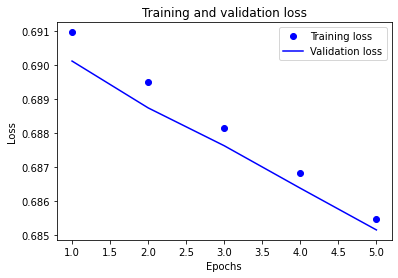

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

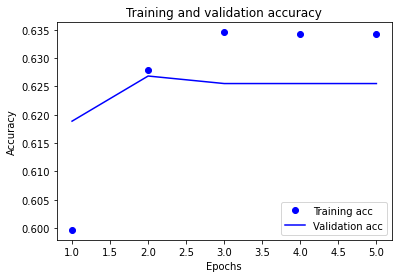

In [ ]:
plt.clf()   # 図のクリア

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### SHAPの適用

In [ ]:
!pip install shap
!pip install japanize-matplotlib

import shap
import matplotlib.pyplot as plt
import japanize_matplotlib 

In [ ]:
train_summary = shap.kmeans(train_data[:len(train_data)],10)
explainer = shap.KernelExplainer(model, train_summary)

In [ ]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

NameError: ignored

In [ ]:
shap_values = explainer.shap_values(test_data[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
num2word = {}
for w in dictionary.keys():
    num2word[dictionary[w]] = w

In [ ]:
shap_values[0].shape

(10, 256)

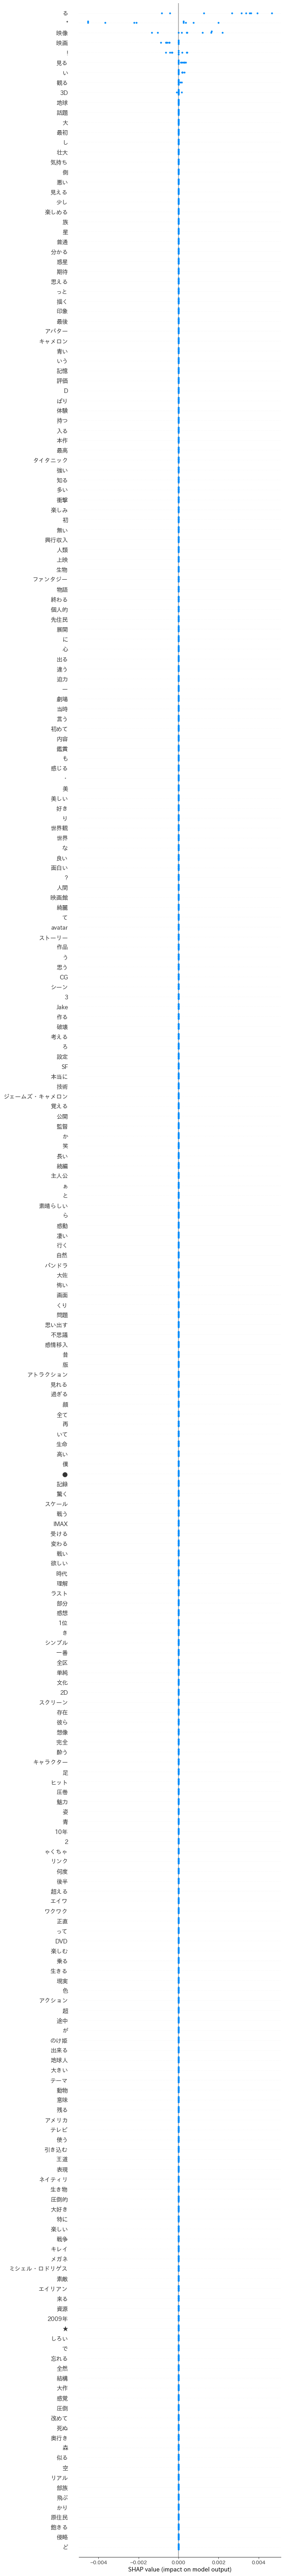

In [ ]:
plt.figure(figsize=(8, 6))

shap.summary_plot(
    shap_values[0], 
    feature_names = list(num2word.values()),
    max_display= 1000,
    )